# Titanic Data Cleaning

A look at Kaggle's Titanic dataset. In this notebook I will be cleaning both the train and test sets and using SciKit to form predictive models.

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#
# set float values to display to 2 d.p. only
pd.options.display.float_format = "{:,.2f}".format

# load titanic data
titanic_train = pd.read_csv("./data/train.csv")
titanic_test = pd.read_csv("./data/test.csv")
gender_submission = pd.read_csv("./data/gender_submission.csv")

# append outcomes to titanic test data
titanic_test['Survived'] = gender_submission['Survived']

# create full dataset
titanic_full = titanic_train.append(titanic_test)
titanic_full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.00,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.00,C85,C,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.00,NaN,S,7.92,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.00,C123,S,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.00,NaN,S,8.05,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


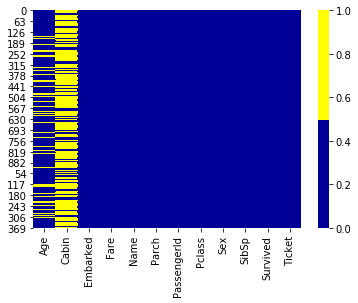

In [79]:
# Visualise missing data from each column. This is to identify columns that might be worth removing. 
colours = ['#000099', '#ffff00']
sns.heatmap(titanic_full.isnull(), cmap=sns.color_palette(colours))

The heatmap shows there is a large absence of data in the Cabin field. This is not numeric data and therefore can not be replaced with average values, so I will drop it from the dataset. The missing Age fields can be filled out with a mean average.

In [80]:
# Remove Cabin column
titanic_full_cln = titanic_full.drop(["Cabin"], axis=1)

# Replace age NaNs with average age
titanic_full_cln['Age'] = titanic_full_cln['Age'].fillna(titanic_full_cln['Age'].mean())

titanic_full_cln

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.00,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.00,C,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.00,S,7.92,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.00,S,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.00,S,8.05,"Allen, Mr. William Henry",0,5,3,male,0,0,373450
...,...,...,...,...,...,...,...,...,...,...,...
413,29.88,S,8.05,"Spector, Mr. Woolf",0,1305,3,male,0,0,A.5. 3236
414,39.00,C,108.90,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,1,PC 17758
415,38.50,S,7.25,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,0,SOTON/O.Q. 3101262
416,29.88,S,8.05,"Ware, Mr. Frederick",0,1308,3,male,0,0,359309


29.881137667304014